## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2019.

# Assignment 1, Task 2: Multilayer Perceptron (MLP)
You will get to know how to build basic fully connected neural network.

In [3]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from utils.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [4]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./utils/layer_funcs.py**. The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [6]:
from utils.layer_funcs import affine_forward
from utils.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function -- H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./utils/layer_funcs.py**.  The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [7]:
from utils.layer_funcs import relu_forward
from utils.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## You can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)
## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
out_tf = tf.nn.relu(x_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)[0]
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./utils/layer_funcs.py**.  The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [8]:
from utils.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= x_tf, labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy)
dx_tf = tf.gradients(loss, x)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(loss_tf, x_tf)
with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

Now try to combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./utils/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b}).$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./utils/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./utils/layer_utils.py**. The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [9]:
from utils.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

out_tf = affine_layer(x_tf, w_tf, b_tf)
init = tf.global_variables_initializer()
    
dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)
    
## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./utils/layer_utils.py**. The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [10]:
## First, let's make a dense layer
from utils.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def dense_layer(x, w, b):
    return tf.nn.relu(tf.matmul(x, w) + b)

out_tf = dense_layer(x_tf, w_tf, b_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: More Backpropogation

Complete the class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. The correctnes of of the solution will be checked by the following Jupyter notebook cells.

In [11]:
from utils.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## Check loss by tensorflow
x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.uint8, shape=(None,))

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4 * L2_loss 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf, feed_dict={x_tf: X_dev, y_tf: y_dev})
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [12]:
from utils.train_funcs import train, test

#### Start training
We have provide you the **train( )** function in **./utils/train_func.py**

In [13]:
from utils.classifiers.twolayernet import TwoLayerNet

## TODO: Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 4.799732638507539
10000/49000 loss: 2.8390164846063177
15000/49000 loss: 2.3290642140068267
20000/49000 loss: 2.3703891491444464
25000/49000 loss: 2.3856971572225074
30000/49000 loss: 2.2387249277042054
35000/49000 loss: 2.1947806399190517
40000/49000 loss: 2.173933877021545
45000/49000 loss: 2.1442116160718716
epoch 1: valid acc = 0.226, new learning rate = 0.000475
5000/49000 loss: 2.131824666519268
10000/49000 loss: 2.1472719942696874
15000/49000 loss: 2.1099227038565718
20000/49000 loss: 2.044745538506588
25000/49000 loss: 2.0722818913214156
30000/49000 loss: 1.961938062922497
35000/49000 loss: 1.9946431971586351
40000/49000 loss: 2.008013875379093
45000/49000 loss: 1.9532278205344031
epoch 2: valid acc = 0.28, new learning rate = 0.00045125
5000/49000 loss: 1.898362378279208
10000/49000 loss: 1.9357167233840358
15000/49000 loss: 1.912906309867441
20000/49000 loss: 1.9021096522782592
25000/49000 loss: 1.9466835407856289
30000/4900

0.4339

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

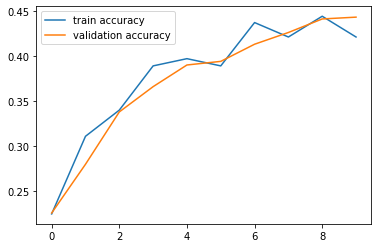

In [14]:
## TODO: plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [15]:
from utils.display_funcs import visualize_pics

num of feature vectors: 100


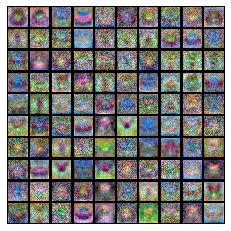

In [16]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Get test accuracy greater than 50%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 50%. If your accuracy is lower, for each 1% lower than 50%, you will lose 5 points.

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc.
4. Early-stopping.
5. Good (better) initial values for weights in the model.
6. Try use PCA or other preprocessing methods. (Try task3-dim_reduction.ipynb before finishing this task)

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```

<span style="color:red"><strong>TODO</strong></span>: See below

In [18]:
from utils.classifiers.twolayernet import TwoLayerNet
# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to below, using your parameter specs:
model = TwoLayerNet(input_dim=3072, hidden_dim=160, num_classes=10, reg=1e-4, weight_scale=1e-3)
num_epoch = 21
batch_size = 600
lr = 1e-3
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, num_epoch=num_epoch, 
                                     batch_size=batch_size, learning_rate=lr, optim='SGD', verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 81
6000/49000 loss: 2.866350553151789
12000/49000 loss: 2.3861571452446335
18000/49000 loss: 2.2352892231046217
24000/49000 loss: 2.169169015689838
30000/49000 loss: 2.163055488599157
36000/49000 loss: 2.0810774186854717
42000/49000 loss: 2.0152077737431706
48000/49000 loss: 2.0140428192345627
epoch 1: valid acc = 0.258, new learning rate = 0.00095
6000/49000 loss: 1.9407505344494815
12000/49000 loss: 1.9209838203164238
18000/49000 loss: 1.9057109924660685
24000/49000 loss: 1.862035796067049
30000/49000 loss: 1.84379761409877
36000/49000 loss: 1.7744779861584883
42000/49000 loss: 1.8315023186214785
48000/49000 loss: 1.811021527011213
epoch 2: valid acc = 0.37, new learning rate = 0.0009025
6000/49000 loss: 1.836108652818831
12000/49000 loss: 1.756621966271622
18000/49000 loss: 1.7458586777094112
24000/49000 loss: 1.752522543077142
30000/49000 loss: 1.757656453423004
36000/49000 loss: 1.7048667564811533
42000/49000 loss: 1.7532264788068532
48000/49000 los

0.5078

#### <span style="color:red"><strong>TODO</strong></span>: Show your best result, including accuracy and weights of the first layer

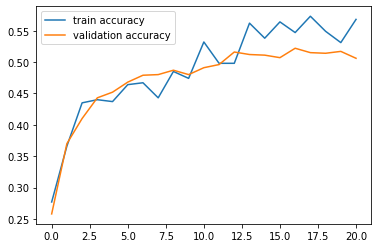

In [19]:
## TODO: plot training and validation accuracy
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

num of feature vectors: 160


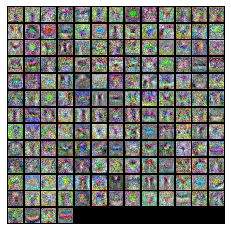

In [20]:
## TODO: Visualize weights
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
visualize_pics(pics)

### Save your best model in a dictionary 

In [21]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [22]:
## A template of loading your model
with open("./save_models/best_model.pkl", "rb") as input_file:
    load_params = pickle.load(input_file)
    
model.update_model(load_params)

## Part 3: Multilayer Net 

Complete the class **MLP** in **./utils/classifiers/mlp.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete the class **MLP** in **./utils/classifiers/mlp.py**

In [23]:
from utils.classifiers.mlp import MLP

## TODO: Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
epoch 1: valid acc = 0.178, new learning rate = 0.0095
epoch 2: valid acc = 0.204, new learning rate = 0.009025
epoch 3: valid acc = 0.237, new learning rate = 0.00857375
epoch 4: valid acc = 0.269, new learning rate = 0.0081450625
epoch 5: valid acc = 0.328, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.393, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.4, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.436, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.451, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.472, new learning rate = 0.005987369392383786
test acc: 0.45


0.45

## Part 4: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 3 or 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [27]:
#space is not enough for original code
hidden_dim = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
b2_tf = tf.Variable(np.zeros((10,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.13600000739097595
epoch 2: valid acc = 0.31700000166893005
epoch 3: valid acc = 0.3799999952316284
epoch 4: valid acc = 0.4009999930858612
epoch 5: valid acc = 0.4300000071525574
epoch 6: valid acc = 0.453000009059906
epoch 7: valid acc = 0.47200000286102295
epoch 8: valid acc = 0.4909999966621399
epoch 9: valid acc = 0.49900001287460327
epoch 10: valid acc = 0.5059999823570251
test acc = 0.5059999823570251


In [30]:
## Demo: Two-layer net in tensorflow.
#space is not enough for the code
hidden_dim = 100
reg_tf = tf.constant(0.01)

tf.reset_default_graph()
# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
        self.b2 = tf.Variable(np.zeros((10,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= out, labels=tf.one_hot(targets,10))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss 

# calculate gradients and do optimization
def step(model, inputs, targets, reg = tf.constant(0.01)):
    loss_value = loss(model, inputs, targets, reg=reg)
    return tf.train.GradientDescentOptimizer(1e-3).minimize(loss_value)

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.argmax(model(inputs),1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 10
with tf.Session() as sess:
    model = Model()
    x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
    y_tf = tf.placeholder(tf.int64, shape=(None,))
    train_step = step(model, x_tf, y_tf)
    accuracy = eval_acc(model, x_tf, y_tf)
    init = tf.global_variables_initializer()
    sess.run(init)
    for e in range(num_epochs):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_test, y_tf: y_test})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.20000000298023224
epoch 2: valid acc = 0.24400000274181366
epoch 3: valid acc = 0.3059999942779541
epoch 4: valid acc = 0.3160000145435333
epoch 5: valid acc = 0.3540000021457672
epoch 6: valid acc = 0.36399999260902405
epoch 7: valid acc = 0.3720000088214874
epoch 8: valid acc = 0.3840000033378601
epoch 9: valid acc = 0.38999998569488525
epoch 10: valid acc = 0.41100001335144043


InternalError: Dst tensor is not initialized.
	 [[{{node _arg_Placeholder_0_0}}]]
	 [[node Mean_1 (defined at <ipython-input-30-975f0d6965da>:35) ]]

### More layers

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" or "dictionary" to store your network parameters, ie., self.W and self.b. Besides, consider to use a loop to create your MLP network.

In [31]:
## For example
#self.W = {
#    'w1': tf.Variable(),
#    'w2': tf.Variable()),
#    'w3': tf.Variable()),
#    'w4': tf.Variable()),
#    ...
#}
hidden_dim = [100,100]
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim[0]).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim[0],)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim[0], hidden_dim[1]).astype('float32'))
b2_tf = tf.Variable(np.zeros((hidden_dim[1],)).astype('float32'))
W3_tf = tf.Variable(1e-2*np.random.rand(hidden_dim[1], 10).astype('float32'))
b3_tf = tf.Variable(np.zeros((10,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.nn.relu(tf.matmul(h1_tf, W2_tf) + b2_tf)
h3_tf = tf.matmul(h2_tf, W3_tf) + b3_tf

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h3_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)+tf.nn.l2_loss(W3_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.08699999749660492
epoch 2: valid acc = 0.08699999749660492
epoch 3: valid acc = 0.06700000166893005
epoch 4: valid acc = 0.06599999964237213
epoch 5: valid acc = 0.06700000166893005
epoch 6: valid acc = 0.06700000166893005
epoch 7: valid acc = 0.06700000166893005
epoch 8: valid acc = 0.06700000166893005
epoch 9: valid acc = 0.06700000166893005
epoch 10: valid acc = 0.06700000166893005
test acc = 0.06700000166893005
